Use neural network to generate PID parameters. Neural network is trained using a model of the plant so we don't need to know jacobian of plant. Model is trained on plant outputs offline using LSTM.

V4.1 Branched from V3.X.4 (Replaced model NN with LSTM)
V4.2 Removed limit on I term

In [3]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
import tensorflow as tf
from tensorflow.python.framework import ops

In [4]:
d_t = 0.01
d_t_decimal = str(d_t)[::-1].find('.')
steps = 1500

In [5]:
class PID:
    def __init__(self, Kp=0, Ki=0, Kd=0):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
#         self.I_max = 5
        self.e = 0
        self.t = 0
        self.e_prev = 0
        self.t_prev = 0
        self.P = 0
        self.I = 0
        self.D = 0
        self.u = 0
        
    def set_state(self, e, t):
        self.e = e
        self.t = t
        
    def update(self, Kp=None, Ki=None, Kd=None):
        if Kp is not None and Ki is not None and Kd is not None:
            self.Kp = Kp
            self.Ki = Ki
            self.Kd = Kd
        
        delta_time = self.t - self.t_prev
        delta_error = self.e - self.e_prev
        
        self.P = self.e
        
        self.I += self.e * delta_time

#         if (self.I < -self.I_max):
#             self.I = -self.I_max
#         elif (self.I > self.I_max):
#             self.I = self.I_max

        if delta_time > 0:
            self.D = delta_error / delta_time
        else:
            self.D = 0

        self.t_prev = self.t
        self.e_prev = self.e

        self.u = self.Kp * self.P + self.Ki * self.I + self.Kd * self.D
        return np.float32(self.u)
        
    def d_update(self, Kp, Ki, Kd):
        return np.float32(self.P), np.float32(self.I), np.float32(self.D)
    
    def reset(self):
        self.e = 0
        self.t = 0
        self.e_prev = 0
        self.t_prev = 0
        self.P = 0
        self.I = 0
        self.D = 0
        self.u = 0


In [6]:
def plant_process(y, t, u):
    K = 0.01
    tau = 1.0
    T = 0.2
    
    t_delay = round(t-T, d_t_decimal)
    if (t_delay<= 0) or (t_delay<0.0):
        u_delay = u[0]
    else:
        step_t = int(t_delay/d_t)-1
        if step_t >= steps:
            u_delay = u[-1]
        else: 
            u_delay = u[step_t]  
        
    dydt = (-y + K*u_delay)/tau
    return dydt

def plant(y_0, t1, t2, u):
    ts = [t1, t2]
    return odeint(plant_process, y_0, ts, args=(u,))[1]

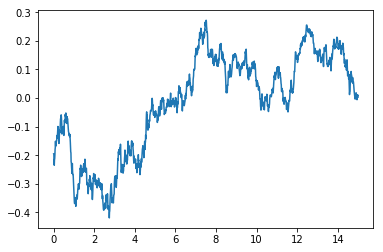

In [7]:
interval = 200
r_steps = steps//interval

r_sq = np.zeros(steps)
up = -1

for i in range(r_steps):
    if i < r_steps-1:
        r_sq[i * interval:(i+1)*interval] = up
    else:
        r_sq[i * interval:] = up
    if up > 0:
        up = -1
    else:
        up = 1

t = np.linspace(0, d_t*steps, steps)
r_sin = np.sin(t)

def gen_rand_sig(t):
    N = 1000
    x = np.random.normal(scale=10.0, size=len(t))
    return np.convolve(x, np.ones((N,))/N)[(N-1):] 
    
r_rand = gen_rand_sig(t)
plt.plot(t, r_rand)

r_combo = np.append(r_sin[:steps//2], r_sq[steps//2:])

### Plant control with neural network

In [11]:
pid = PID(1, 1, 1)

np_update = np.vectorize(pid.update)
np_d_update = np.vectorize(pid.d_update)

def tf_d_update(Kp, Ki, Kd,name=None):
    with tf.name_scope(name, "d_update", [Kp, Ki, Kd]) as name:
        y = tf.py_func(np_d_update,
                        [Kp, Ki, Kd],
                        (tf.float32, tf.float32, tf.float32),
                        name=name,
                        stateful=False)
        return y

def py_func(func, inp, Tout, stateful=True, name=None, grad=None):

    # Need to generate a unique name to avoid duplicates:
    rnd_name = 'PyFuncGrad' + str(np.random.randint(0, 1E+8))

    tf.RegisterGradient(rnd_name)(grad)  # see _MySquareGrad for grad example
    g = tf.get_default_graph()
    with g.gradient_override_map({"PyFunc": rnd_name}):
        return tf.py_func(func, inp, Tout, stateful=stateful, name=name)
    
def updategrad(op, grad):
    Kp, Ki, Kd = op.inputs
    
    dudKp, dudKi, dudKd = tf_d_update(Kp, Ki, Kd)
    return grad * dudKp, grad * dudKi, grad * dudKd


def tf_update(Kp, Ki, Kd, name=None):

    with tf.name_scope(name, "update", [Kp, Ki, Kd]) as name:
        y = py_func(np_update,
                        [Kp, Ki, Kd],
                        [tf.float32],
                        name=name,
                        grad=updategrad)  # <-- here's the call to the gradient
        return y[0]

num_nodes = 64
input_size = 1

hpKp1 = 8
hpKi1 = 8
hpKd1 = 8
hpKp2 = 3
hpKi2 = 3
hpKd2 = 3

graph = tf.Graph()
with graph.as_default():
    
    tf_r = tf.placeholder(tf.float32,shape=())
    tf_u = tf.placeholder(tf.float32,shape=())
    tf_y = tf.placeholder(tf.float32,shape=())
    tf_e = tf.placeholder(tf.float32,shape=())
    tf_learning_rate = tf.placeholder(tf.float32, shape=())

              
    # PID param NN
    wpid_Kp_1 = tf.Variable(tf.truncated_normal([1, hpKp1]))
    bpid_Kp_1 = tf.Variable(tf.ones([hpKp1]))   
    wpid_Kp_2 = tf.Variable(tf.truncated_normal([hpKp1, hpKp2]))
    bpid_Kp_2 = tf.Variable(tf.ones([hpKp2]))
    wpid_Kp_3 = tf.Variable(tf.truncated_normal([hpKp2, 1]))
    bpid_Kp_3 = tf.Variable(tf.ones([1]))
    
    wpid_Ki_1 = tf.Variable(tf.truncated_normal([1, hpKi1]))
    bpid_Ki_1 = tf.Variable(tf.ones([hpKi1]))   
    wpid_Ki_2 = tf.Variable(tf.truncated_normal([hpKi1, hpKi2]))
    bpid_Ki_2 = tf.Variable(tf.ones([hpKi2]))
    wpid_Ki_3 = tf.Variable(tf.truncated_normal([hpKi2, 1]))
    bpid_Ki_3 = tf.Variable(tf.ones([1]))
    
    wpid_Kd_1 = tf.Variable(tf.truncated_normal([1, hpKd1]))
    bpid_Kd_1 = tf.Variable(tf.ones([hpKd1]))   
    wpid_Kd_2 = tf.Variable(tf.truncated_normal([hpKd1, hpKd2]))
    bpid_Kd_2 = tf.Variable(tf.ones([hpKd2]))
    wpid_Kd_3 = tf.Variable(tf.truncated_normal([hpKd2, 1]))
    bpid_Kd_3 = tf.Variable(tf.ones([1]))
    
    #LSTM
    # Forget gate: input, previous output, and bias.
    fx = tf.Variable(tf.truncated_normal([input_size, num_nodes]))
    fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes]))
    fb = tf.Variable(tf.zeros([1, num_nodes]))
    # Input gate: input, previous output, and bias.
    ix = tf.Variable(tf.truncated_normal([input_size, num_nodes]))
    im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes]))
    ib = tf.Variable(tf.zeros([1, num_nodes]))
    # Memory cell: input, state and bias.                             
    cx = tf.Variable(tf.truncated_normal([input_size, num_nodes]))
    cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes]))
    cb = tf.Variable(tf.zeros([1, num_nodes]))
    # Output gate: input, previous output, and bias.
    ox = tf.Variable(tf.truncated_normal([input_size, num_nodes]))
    om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes]))
    ob = tf.Variable(tf.zeros([1, num_nodes]))
    # Variables saving state across unrollings.
    saved_output = tf.Variable(tf.zeros([1, num_nodes]), trainable=False)
    saved_state = tf.Variable(tf.zeros([1, num_nodes]), trainable=False)
    # Classifier weights and biases.
    wm = tf.Variable(tf.truncated_normal([num_nodes, 1]))
    bm = tf.Variable(tf.zeros([1]))
    
    def lstm_cell(i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""
        # i is the current input
        # o is the previous hidden state (i.e. h_t-1)
        # state is the previous state (i.e. C_t-1)
        x_weights = tf.concat([fx, ix, cx, ox], axis=1)
        m_weights = tf.concat([fm, im, cm, om], axis=1)
        
        matmul_i = tf.matmul(i, x_weights)
        matmul_o = tf.matmul(o, m_weights)
        
        # Determine what to forget based on input and prev output
        forget_gate = tf.sigmoid(
            matmul_i[:, :num_nodes] + matmul_o[:, :num_nodes] + fb)
        
        # Determine what to pass into state based on input and prev output
        input_gate = tf.sigmoid(
            matmul_i[:, num_nodes:num_nodes*2] + matmul_o[:, num_nodes:num_nodes*2] + ib)
      
        # Transform current input and prev output
        update = matmul_i[:, num_nodes*2:num_nodes*3] + matmul_o[:, num_nodes*2:num_nodes*3] + cb
        
        # Update state. 
        # Forget some of the state determined by the forget gate
        # Add part of input and prev output (Contained in update) determined by input gate
        # Update is in tanh to force between -1 and 1
        state = forget_gate * state + input_gate * tf.tanh(update)
        
        # Determine what to pass into output from state based on input and prev output
        output_gate = tf.sigmoid(
            matmul_i[:, num_nodes*3:num_nodes*4] + matmul_o[:, num_nodes*3:num_nodes*4] + ob)
        
        # Filter state with what was determined in the last step, and set it as the output
        return output_gate *  tf.tanh(state), state
        # i.e. return h_t, C_t
    
    def run_lstm(X):
        output = saved_output
        state = saved_state
        output, state = lstm_cell(tf.reshape(X, (1, 1)), output, state)

        # State saving across unrollings
        # This will save the state for the next batch
        with tf.control_dependencies([saved_output.assign(output),
                                     saved_state.assign(state)]):
            
            return tf.matmul(output, wm) + bm

    
    # Forward prop model offline
    y_model_offline = run_lstm(tf.reshape(tf_u, (1, 1)))
 
    def pid_fp(input_value, w1, b1, w2, b2, w3, b3):
        z1 = tf.matmul(input_value, w1) + b1
        a1 = tf.nn.leaky_relu(z1)
        z2 = tf.matmul(a1, w2) + b2
        a2 = tf.nn.leaky_relu(z2)
        return tf.matmul(a2, w3) + b3
    
    # Forward prop PID
    e_rs = tf.reshape(tf_e, (1, 1))
    
    Kp = pid_fp(e_rs, wpid_Kp_1, bpid_Kp_1, wpid_Kp_2, bpid_Kp_2, wpid_Kp_3, bpid_Kp_3)
    Ki = pid_fp(e_rs, wpid_Ki_1, bpid_Ki_1, wpid_Ki_2, bpid_Ki_2, wpid_Ki_3, bpid_Ki_3)
    Kd = pid_fp(e_rs, wpid_Kd_1, bpid_Kd_1, wpid_Kd_2, bpid_Kd_2, wpid_Kd_3, bpid_Kd_3)
    
    Kp_abs = tf.math.abs(Kp)
    Ki_abs = tf.math.abs(Ki)
    Kd_abs = tf.math.abs(Kd)
    
    u_nn = tf_update(Kp_abs, Ki_abs, Kd_abs)
#     u_nn = tf_update(Kp, Ki, Kd)

    
    # Forward prop model online
    y_model_online = run_lstm(u_nn)

    
    model_var_list = [fx, fm, fb, ix, im, ib, cx, cm, cb, ox, om, ob, wm, bm]
    model_loss = tf.losses.mean_squared_error(tf_y, tf.reshape(y_model_offline, ()))
    model_opt = tf.train.AdamOptimizer(tf_learning_rate).minimize(model_loss, var_list=model_var_list)

    pid_var_list = [wpid_Kp_1, bpid_Kp_1, wpid_Kp_2, bpid_Kp_2, wpid_Kp_3, bpid_Kp_3,
                   wpid_Ki_1, bpid_Ki_1, wpid_Ki_2, bpid_Ki_2, wpid_Ki_3, bpid_Ki_3,
                   wpid_Kd_1, bpid_Kd_1, wpid_Kd_2, bpid_Kd_2, wpid_Kd_3, bpid_Kd_3]
    pid_loss = tf.losses.mean_squared_error(tf_r, tf.reshape(y_model_online, ()))
    pid_opt = tf.train.AdamOptimizer(tf_learning_rate).minimize(pid_loss, var_list=pid_var_list)


In [12]:
epochs = 10

y_0 = 0
y_p_offline = np.zeros(steps)
y_m_offline = np.zeros(steps)

y_p_online = np.zeros(steps)
y_m_online = np.zeros(steps)
u_offline = np.zeros(steps)
u_online = np.zeros(steps)

Kp = np.zeros(steps)
Ki = np.zeros(steps)
Kd = np.zeros(steps)

offline_loss = np.zeros(steps * epochs)
online_loss = np.zeros(steps * epochs) 



r_offline = r_sq
r_online = r_sq


offline_lr = 0.005
online_lr = 0.005

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    for j in range(epochs):
       
        #Reset values
        y_0 = 0
        y_p_offline = np.zeros(steps)
        y_m_offline = np.zeros(steps)
        u_offline = np.zeros(steps)
        session.run(saved_output.initializer)
        session.run(saved_state.initializer)
        
        print("Start epoch", j)
        for i in range(steps)[1:]:
            
            e = r_offline[i] - y_p_offline[i-1]

            t_prev = t[i-1]
            t_cur = t[i]
            pid.set_state(e, t_cur)
            u_offline[i] = pid.update()
            # Get plant output
            y_p_offline[i] = plant(y_0, t_prev, t_cur, u_offline)
            
            # Train model on plant output
            feed_dict = {tf_y:y_p_offline[i], tf_u:u_offline[i], tf_learning_rate:offline_lr}
            _, offline_loss[i + j*steps], y_m_offline[i] = session.run([model_opt, model_loss, y_model_offline], 
                                                             feed_dict=feed_dict)

            y_0 = y_p_offline[i]
            
        print("Offline loss", sum(offline_loss[j * steps:i + j*steps])/(i + j*steps))

        #Reset values
        y_0 = 0
        y_p_online = np.zeros(steps)
        y_m_online = np.zeros(steps)
        u_online = np.zeros(steps)
        session.run(saved_output.initializer)
        session.run(saved_state.initializer)
        
        for i in range(steps)[1:]:  

            e = r_online[i] - y_p_online[i-1]
            t_prev = t[i-1]
            t_cur = t[i]
            pid.set_state(e, t_cur)

            # Get get PID parameters and get control signal
            # Send to model to train PID param NN
            feed_dict = {tf_e:e, tf_r:r_online[i], tf_learning_rate:online_lr}
            _, online_loss[i + j*steps], y_m_online[i], u_online[i] = session.run([pid_opt, pid_loss, 
                                                                                   y_model_online, u_nn], 
                                                    feed_dict=feed_dict)
            y_p_online[i] = plant(y_0, t_prev, t_cur, u_online)
            y_0 = y_p_online[i]
            
        print("Online loss", sum(online_loss[j * steps:i + j*steps])/(i + j*steps))

    #Reset values
    y_0 = 0
    y_p_online = np.zeros(steps)
    y_m_online = np.zeros(steps)
    u_online = np.zeros(steps)
    session.run(saved_output.initializer)
    session.run(saved_state.initializer)
    
    for i in range(len(t))[1:]:  
        
        e = r_online[i] - y_p_online[i-1]
        t_prev = t[i-1]
        t_cur = t[i]
        pid.set_state(e, t_cur)
        
        # Get get PID parameters and get control signal
        # Send to model to train PID param NN
        feed_dict = {tf_e:e, tf_r:r_online[i], tf_learning_rate:online_lr}
        y_m_online[i], u_online[i] = session.run([y_model_online, u_nn], feed_dict=feed_dict)
        Kp[i] = pid.Kp
        Ki[i] = pid.Ki
        Kd[i] = pid.Kd
        
        y_p_online[i] = plant(y_0, t_prev, t_cur, u_online)
        y_0 = y_p_online[i]

Start epoch 0
Offline loss 0.6557891920852038
Online loss 0.1821899509678882
Start epoch 1
Offline loss 0.036678806739169914
Online loss 1.3315759947253156
Start epoch 2
Offline loss 0.005395008253587868
Online loss 0.8358291109597481
Start epoch 3
Offline loss 0.004390848465883619
Online loss 0.5007067535093408
Start epoch 4
Offline loss 0.012173524712042348
Online loss 0.39318824164616073
Start epoch 5
Offline loss 0.003563457745543027
Online loss 0.4552509877144593
Start epoch 6
Offline loss 0.0023610124038528865
Online loss 0.21721978478203932
Start epoch 7
Offline loss 0.0022031120851190526
Online loss 0.26278860920868463
Start epoch 8
Offline loss 0.0024996137649248825
Online loss 0.1578280525619396
Start epoch 9
Offline loss 0.002304409558364927
Online loss 0.18076072765100845


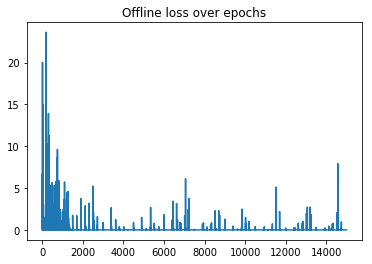

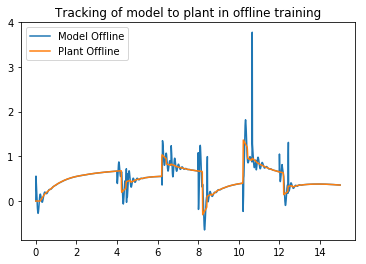

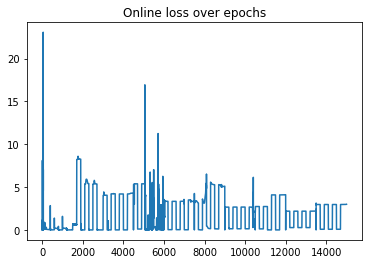

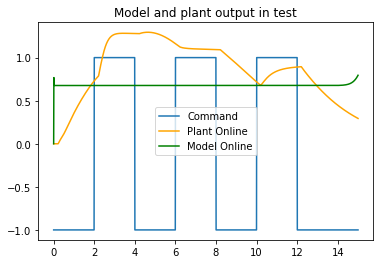

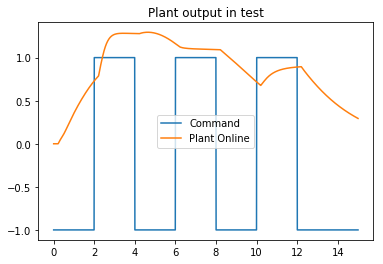

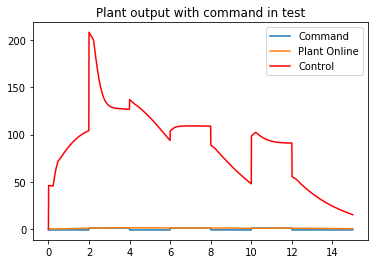

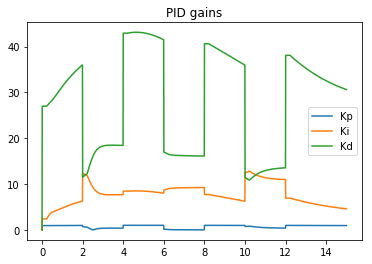

In [13]:
plt.plot(offline_loss)
plt.title('Offline loss over epochs')
plt.show()

plt.plot(t, y_m_offline)
plt.plot(t, y_p_offline)
plt.title('Tracking of model to plant in offline training')
plt.legend(('Model Offline', 'Plant Offline'))
plt.show()

plt.plot(online_loss)
plt.title('Online loss over epochs')
plt.show()

plt.plot(t, r_sq)
plt.plot(t, y_p_online, color='orange')
plt.plot(t, y_m_online, color='green')
plt.title('Model and plant output in test')
plt.legend(('Command', 'Plant Online', 'Model Online'))
plt.show()

plt.plot(t, r_sq)
plt.plot(t, y_p_online)
plt.title('Plant output in test')
plt.legend(('Command', 'Plant Online'))
plt.show()

plt.plot(t, r_sq)
plt.plot(t, y_p_online)
plt.plot(t, u_online, color='red')
plt.title('Plant output with command in test')
plt.legend(('Command', 'Plant Online', 'Control'))
plt.show()

plt.plot(t, Kp)
plt.plot(t, Ki)
plt.plot(t, Kd)
plt.title('PID gains')
plt.legend(('Kp', 'Ki', 'Kd'))
plt.show()